## Lines from `Galaxy` objects

To generate lines from components of a `Galaxy` (i.e. parametric or particle based stars or black holes) `synthesizer` provides ``get_lines`` methods on component and galaxy objects.
These methods are analogous to those on a grid, and return a `LineCollection` containing the requested lines (which can either be singular, doublets, triplets, or more).

In [1]:
from unyt import Myr, kelvin

import synthesizer.line_ratios as line_ratios
from synthesizer.emission_models import BimodalPacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, Stars, ZDist

# Get a grid
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

# Make a parametric galaxy
stellar_mass = 10**12
sfh = SFH.Constant(max_age=100 * Myr)
metal_dist = ZDist.Normal(mean=0.01, sigma=0.05)
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
)

# Set up the emission model
model = BimodalPacmanEmission(
    grid=grid,
    tau_v_ism=0.5,
    tau_v_birth=0.7,
    dust_curve_ism=PowerLaw(slope=-1.3),
    dust_curve_birth=PowerLaw(slope=-0.7),
    dust_emission_ism=Blackbody(temperature=100 * kelvin),
    dust_emission_birth=Blackbody(temperature=30 * kelvin),
    fesc=0.2,
    fesc_ly_alpha=0.9,
)

# To get the dust emission at a line we need to first run the
# spectra generation
stars.get_spectra(model)

# Get the lines
lines = stars.get_lines(
    (line_ratios.Hb, line_ratios.O3r, line_ratios.O3b), model
)

print(stars.lines["emergent"])

----------
LINE COLLECTION
number of lines: 3
lines: ['H 1 4861.32A' 'O 3 4958.91A' 'O 3 5006.84A']
available ratios: ['R3']
available diagrams: []
----------


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


In the case of a particle based galaxy you can either get the integrated line emission or per-particle line emission (by using a per particle model) the  with ``get_lines`` method.

In [2]:
from synthesizer.emission_models import PacmanEmission
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG

# Get the stars from a particle based galaxy
stars = load_CAMELS_IllustrisTNG(
    "../../../tests/data/",
    snap_name="camels_snap.hdf5",
    group_name="camels_subhalo.hdf5",
    physical=True,
)[0].stars

# Set up the emission model
model = PacmanEmission(
    grid=grid,
    tau_v=0.7,
    dust_curve=PowerLaw(slope=-1.3),
    dust_emission=Blackbody(temperature=50 * kelvin),
    fesc=0.5,
    fesc_ly_alpha=1.0,
    per_particle=True,
)

# Get the spectra and lines
stars.get_spectra(model)
stars.get_lines((line_ratios.Hb, line_ratios.O3r, line_ratios.O3b), model)
print(stars.lines["emergent"])
print(stars.particle_lines["emergent"])

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


----------
LINE COLLECTION
number of lines: 3
lines: ['H 1 4861.32A' 'O 3 4958.91A' 'O 3 5006.84A']
available ratios: ['R3']
available diagrams: []
----------
----------
LINE COLLECTION
number of lines: 3
lines: ['H 1 4861.32A' 'O 3 4958.91A' 'O 3 5006.84A']
available ratios: ['R3']
available diagrams: []
----------


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


The line luminosities themselves are extracted and stored in the `"nebular"` key of the lines dictionaries. Below we plot the line luminosities and continuum luminosities to compare the different emissions.

Note that we have skipped any lines with little or no contribution.

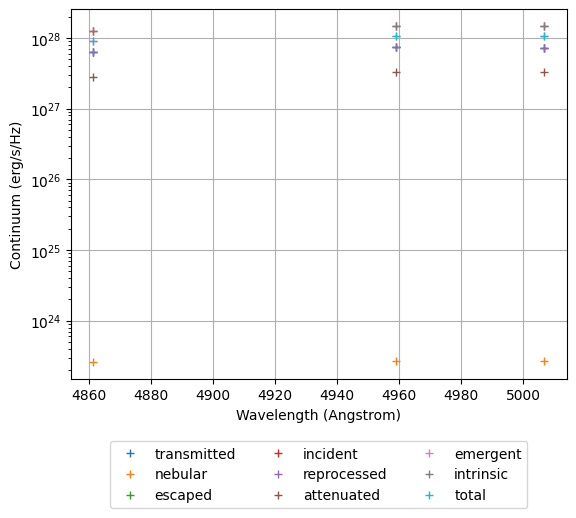

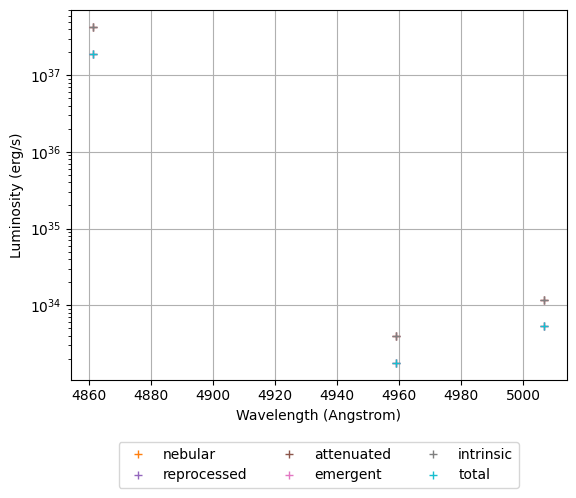

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_axisbelow(True)

# Get the colours
colors = {}
for ind, key in enumerate(stars.lines):
    colors[key] = plt.cm.tab10(ind)

for key in stars.lines:
    # Don't plot dust emission since it's effectively 0
    # for these lines
    if key == "dust_emission":
        continue
    for line_id in stars.lines[key].line_ids:
        ax.semilogy(
            stars.lines[key][line_id].wavelength,
            stars.lines[key][line_id].continuum,
            color=colors[key],
            marker="+",
            linestyle="None",
        )

ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Continuum (erg/s/Hz)")

# Create the legend
legend_handles = []
for key in stars.lines:
    # Don't plot dust emission since it's effectively 0
    # for these lines
    if key == "dust_emission":
        continue
    legend_handles.append(
        plt.Line2D(
            [0],
            [0],
            color=colors[key],
            label=key,
            marker="+",
            linestyle="None",
        )
    )

ax.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
)

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_axisbelow(True)

# Get the colours
colors = {}
for ind, key in enumerate(stars.lines):
    colors[key] = plt.cm.tab10(ind)

for key in stars.lines:
    for line_id in stars.lines[key].line_ids:
        ax.semilogy(
            stars.lines[key][line_id].wavelength,
            stars.lines[key][line_id].luminosity,
            color=colors[key],
            marker="+",
            linestyle="None",
        )

ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Luminosity (erg/s)")

# Create the legend
legend_handles = []
for key in stars.lines:
    # Skip all spectra types where lines are 0
    skip = False
    for line_id in stars.lines[key].line_ids:
        if stars.lines[key][line_id].luminosity.sum() == 0:
            skip = True
            break
    if skip:
        continue
    legend_handles.append(
        plt.Line2D(
            [0],
            [0],
            color=colors[key],
            label=key,
            marker="+",
            linestyle="None",
        )
    )

ax.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
)

plt.show()